## Introduction

This tutorial demonstrates a RGB-D surface reconstruction method implemented in Open3D.

The reconstruction algorithm is a scalable integration algorithm that utilizes a hierarchical hash structure to integrate each RGB-D frame into Truncated Signed Distance Fields (TSDF).

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

## 1. Dataset preparation

The first step in this tutorial is to download datasets and preprocess them.  
In Open3D, there is a helper function to download various demo datasets for various tasks.  

We download and read RGB-D images from a sampled Redwood dataset by using ```SampleRedwoodRGBDImage()``` function in ```open3d.data``` namespace.
Along with the RGB-D frames, we also need the camera trajectory data for each frame. 
We use the below code to read the RGB-D frames and camera poses.

In [2]:
def read_trajectory(filename):
    traj = []
    with open(filename, "r") as f:
        metastr = f.readline()
        while metastr:
            metadata = list(map(int, metastr.split()))
            mat = np.zeros(shape=(4, 4))
            for i in range(4):
                matstr = f.readline()
                mat[i, :] = np.fromstring(matstr, dtype=float, sep=" \t")
            traj.append(mat)
            metastr = f.readline()
    return traj

In [3]:
def prepare_dataset():
    redwood = o3d.data.SampleRedwoodRGBDImages()
    camera_poses = read_trajectory(redwood.odometry_log_path)
    return redwood, camera_poses


redwood, camera_poses = prepare_dataset()

## 2. Visualize data

This code below visualizes all RGB-D frames in the dataset.

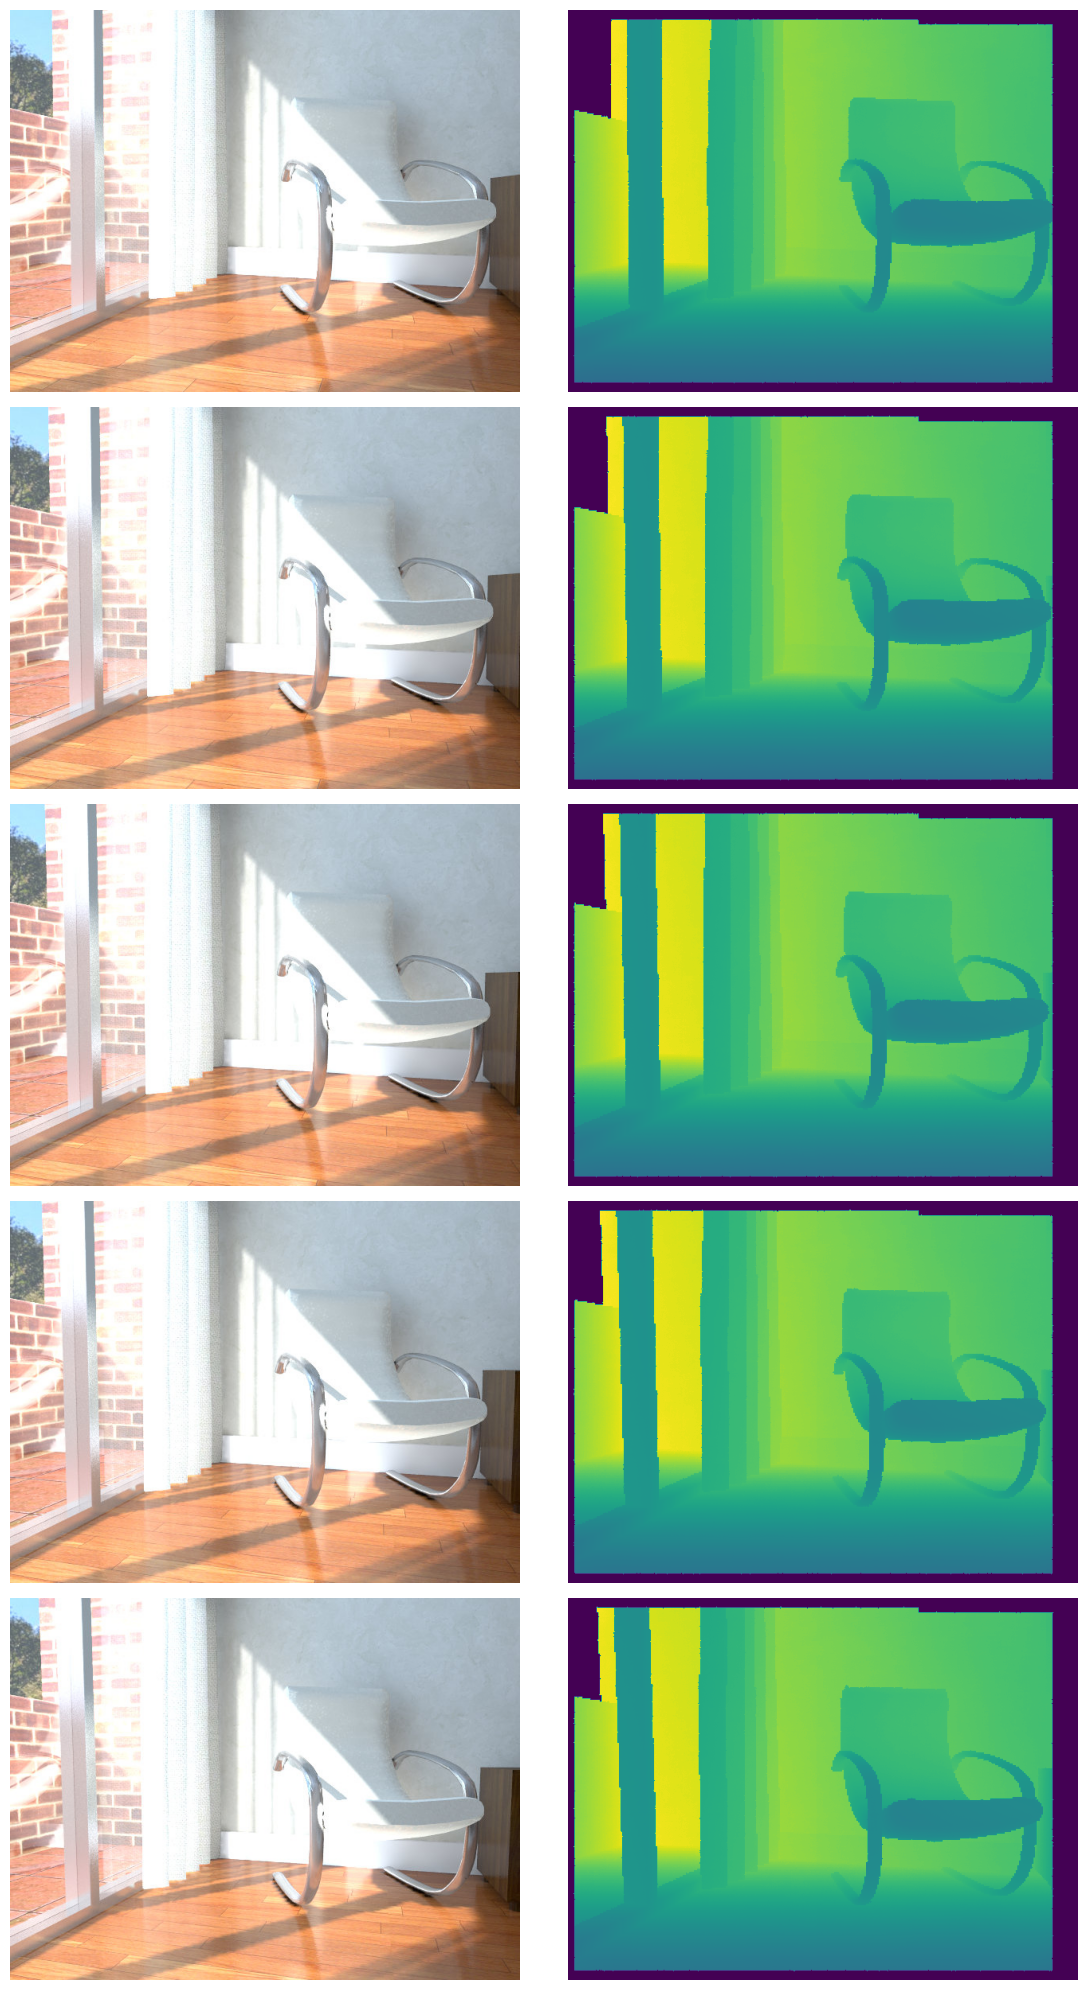

In [4]:
fig = plt.figure(figsize=(12, len(camera_poses) * 4))
for i in range(len(camera_poses)):
    color = o3d.io.read_image(redwood.color_paths[i])
    depth = o3d.io.read_image(redwood.depth_paths[i])
    ax1 = fig.add_subplot(len(camera_poses), 2, 1 + 2 * i)
    ax1.imshow(np.asarray(color))
    ax1.axis("off")
    ax2 = fig.add_subplot(len(camera_poses), 2, 2 + 2 * i)
    ax2.imshow(np.asarray(depth))
    ax2.axis("off")

plt.tight_layout()
plt.show()

## 3. TSDF Volume integration

Open3D provides two types of TSDF volume implementation. 
```ScalableTSDFVolume``` is one of the available implementations, and it implements a hierarchical hash structure for supporting larger scenes.

We can initialize TSDF volume by using the below code.

In [5]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8,
)

## 4. TSDF volume integration

Then, for each RGB-D frame, we unproject the 2D RGB-D image into 3D volume using the camera pose
The unprojected image is then integrated it into the TSDF volume defined in the above cell.

In [6]:
for i in range(len(camera_poses)):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(redwood.color_paths[i])
    depth = o3d.io.read_image(redwood.depth_paths[i])
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False
    )
    volume.integrate(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault
        ),
        np.linalg.inv(camera_poses[i]),
    )

Integrate 0-th image into the volume.
Integrate 1-th image into the volume.
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.


## 5. Extract a mesh

Finally, we can extract a mesh from TSDF volume by using marching cude algorithm. 
In Open3D, ```extract_triangle_mesh``` function of TSDF volume is provided for this purpose.

In [7]:
print("Extract a triangle mesh from the volume and visualize it.")
trimesh = volume.extract_triangle_mesh()
trimesh.compute_vertex_normals()
trimesh = trimesh.translate(-trimesh.get_center())

from jupythree.mesh import mesh

mesh(
    np.asarray(trimesh.vertices),
    np.asarray(trimesh.triangles),
    vertex_color=np.asarray(trimesh.vertex_colors),
).show(width=1200)

Extract a triangle mesh from the volume and visualize it.


Box(children=(VBox(children=(Renderer(camera=PerspectiveCamera(aspect=3.0, position=(0.8, 0.5, 0.8), projectio…